# Subset Selection

This approach involves identifying a subset of the $p$ features (predictors) out of the $k$ that we believe to be related to the response. We then fit a model using OLS on the reduced set of variables.

In [21]:
import pandas as pd
import numpy as np
import patsy
import itertools
import time
import statsmodels.api as sm

hprice2 = pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/hprice2.dta')
f = 'lprice ~ lnox + lproptax + crime + rooms + dist + radial + stratio + lowstat'
y1, X1 = patsy.dmatrices(f, data=hprice2, return_type='dataframe')

In what follows, we will pre-processed the data by demeaning both the outcome and features so all models can be fitted without an intercept.

In [22]:
y = y1.sub(y1.mean())
X = X1.sub(X1.mean()).drop('Intercept',axis=1)

(Code) Source:
1. [http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html)
2. [http://www.science.smith.edu/~jcrouser/SDS293/labs/lab9-py.html](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab9-py.html)

## _Best_ Subset Selection

To perform best subset selection, we fit a separate OLS regression best subset for each possible combination of the $k$ predictors. That is, we fit _all_ $k$ models selection that contain exactly one predictor, all $\left(\begin{array}{l}{k} \\ {2}\end{array}\right)=k(k-1) / 2$ models that contain exactly two predictors, and so forth. We then look at all of the resulting models, with the goal of identifying the one that is best.

***
**Algorithm**: <ins>_Best_ Subset Selection</ins>

1. Let $\mathcal{M}_{0}$ denote the null model, which contains no predictors. This model simply predicts the sample mean for each observation.
2. For $p=1,2, \ldots k$:
 1. Fit all $\left(\begin{array}{l}{k} \\ {p}\end{array}\right)$ models that contain exactly $p$ predictors.
 2. Pick the best among these $\left(\begin{array}{l}{k} \\ {p}\end{array}\right)$ models, and call it $\mathcal{M}_{p}$. Here best is defined as having the smallest $RSS$, or equivalently largest $R^{2}$.

In [23]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = regr.ssr
    return {"model":regr, "RSS":RSS}

In [24]:
def getBest(p):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, p):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", p, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a ```DataFrame``` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors  $p$:

In [25]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()

for i in range(1,9):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


Processed 8 models on 1 predictors in 0.05442237854003906 seconds.
Processed 28 models on 2 predictors in 0.0907750129699707 seconds.
Processed 56 models on 3 predictors in 0.20334744453430176 seconds.
Processed 70 models on 4 predictors in 0.22708368301391602 seconds.
Processed 56 models on 5 predictors in 0.18625617027282715 seconds.
Processed 28 models on 6 predictors in 0.17774677276611328 seconds.
Processed 8 models on 7 predictors in 0.05030250549316406 seconds.
Processed 1 models on 8 predictors in 0.010619163513183594 seconds.
Total elapsed time: 1.0825433731079102 seconds.


C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series

Text(0, 0.5, 'BIC')

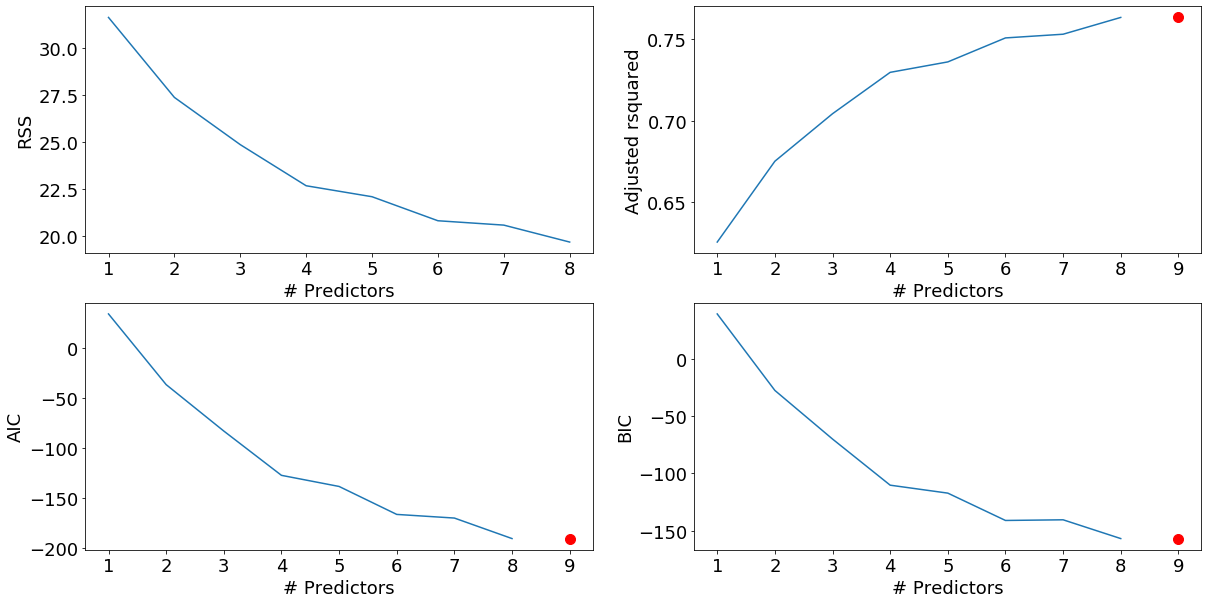

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

***
⚠️ The number of possible models that must be considered grows rapidly as $k$ increases, e.g., if $k$=10, then there are approximately 1,000 possible models to be considered, and if $k=20$, there are over one million possibilities (1,048,576)!

## Stepwise Selection: _Forward_ Stepwise Selection

For computational reason, the previous '_best_ subset selection' cannot be applied with very large $k$ (remember it consinders all $2^k$  possible models). The algorithm begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, untill all the predictors are in the model.

***
**Algorithm**: <ins>_Forward_ Stepwise Selection</ins>

1. Let $\mathcal{M}_{0}$ denote the null model, which contains _no_ predictors.
2. For $p=0,1,2,\ldots, k-1$:
 1. Consider all $k-p$ models that augment the predictors in $\mathcal{M}_{p}$ with one additional predictor.
 2. Choose the _best_ among these $k-p$ models, and call it $\mathcal{M}_{p+1}$. Here best is defined as having smallest $RSS$ or highest $R^{2}$.

In [27]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

3. Select a single best model from among $\mathcal{M}_{0}, \ldots, \mathcal{M}_{k}$ using a *model selection criteria* previously discussed such as cross-validated prediction error, $C_{p}(\mathrm{AIC}), \mathrm{BIC}$, adjusted $R^{2}$, etc.

In [28]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Processed  8 models on 1 predictors in 0.03979134559631348 seconds.
Processed  7 models on 2 predictors in 0.02546072006225586 seconds.
Processed  6 models on 3 predictors in 0.023228168487548828 seconds.
Processed  5 models on 4 predictors in 0.026741743087768555 seconds.
Processed  4 models on 5 predictors in 0.02337503433227539 seconds.
Processed  3 models on 6 predictors in 0.014589071273803711 seconds.
Processed  2 models on 7 predictors in 0.00717926025390625 seconds.
Processed  1 models on 8 predictors in 0.006308317184448242 seconds.
Total elapsed time: 0.23810410499572754 seconds.


C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series

Text(0, 0.5, 'BIC')

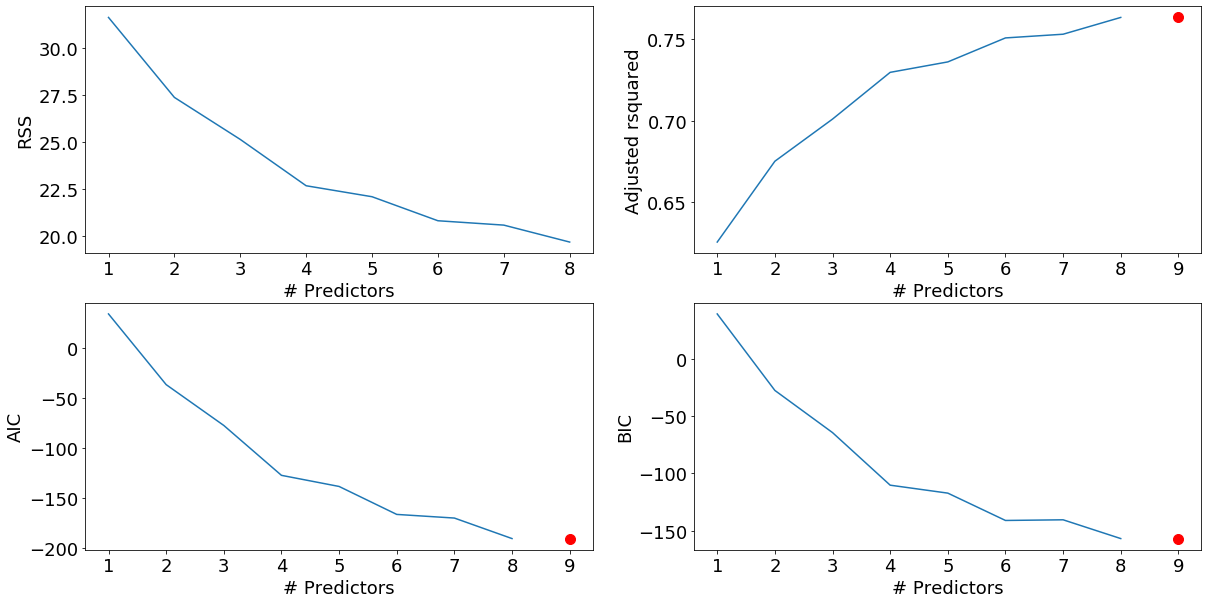

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_fwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

***
⚠️ There are a total of $1+\sum_{p=0}^{k-1}(k-p)=1+\frac{k(k+1)}{2}$ models to be estimated instead of $2^{k}$ as before,
e.g. if $k=20,$ there are 211 models to be estimated! Interestingly it will work even when <font color=blue>$k>n$</font>.

## Stepwise Selection: _Backward_ Stepwise Selection

Unlike forward stepwise selection, it begins with the full least squares model containing all $k$ regressors, and then iteractively the least useful regressors one-at-a-time until there are no predictors in the model, i.e., the null model.

***
**Algorithm**: <ins>_Backward_ Stepwise Selection</ins>

1. Let $\mathcal{M}_{k}$ denote the full model, which contains _all_ $k$ predictors.
2. For $p=k,k-1,\ldots, 1$:
 1. Consider all $p$ models that contain all but one of the predictors in $\mathcal{M}_{p}$ for a total of $p-1$ predictors.
 2. Choose the best among these $p$ models, and call it $\mathcal{M}_{p-1}$. Here best is defined as having smallest RSS or highest $R^{2}$.

In [30]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [41]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

TypeError: processSubset() missing 4 required positional arguments: 'X_train', 'y_train', 'X_test', and 'y_test'

3. Select a single best model from among $\mathcal{M}_{0}, \ldots, \mathcal{M}_{k}$ using a *model selection criteria* previously discussed such as cross-validated prediction error, $C_{p}(\mathrm{AIC}), \mathrm{BIC}$, adjusted $R^{2}$, etc.

C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series

Text(0, 0.5, 'BIC')

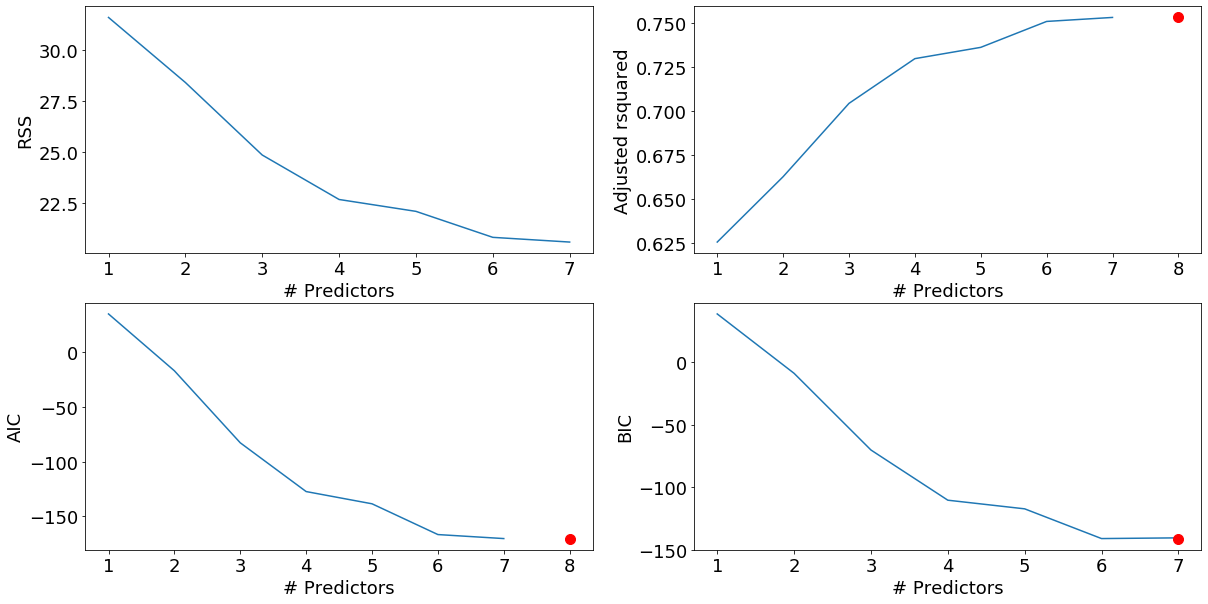

In [32]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('Adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

***
⚠️ Unlike the _forward_ stepwise selection algorithm, this will _only_ work when <font color=blue>$n>k$</font>.

<font color=red><ins>Note</ins> Notice that the $\bar{R}^2$, BIC and $C_p$ are calculated on the training data that have been used to fit the model. This means that, the model selection, using these metrics, is possibly subject to overfitting and may not perform as well when applied to new data.</font>

## Choosing the _Optimal_ Model

All the previous algorithms are good in selecting a model that best fit the training data set (because they all minimize the $RSS$ which is equivalent to maximize the $R^2$  for these observations) and this does not necessarily means they minimize the $RSS$ in any validation data set. Therefore 'training set' $RSS$ and 'training set' $R^2$  cannot be used to select from among a set of models with different numbers of variables if we are meant to use this model for _prediction_. Therefore we can replace step 3 in these algorithms with a step where the __cross-validated prediction error__  is calculated using observations in the validation data set!

💡 Of course you can use other _model selection criteria_ like $\bar{R}^2$, $C_p$ (AIC), BIC, etc., _but_ if we care about the prediction power of our model, the __cross-validated prediction error__ is a more natural choice.

💡 Remember that the $k$-fold Cross-validation consists of first dividing the data into $k$ subsets, also known as $k$-fold, where $k$ is generally set to 5 or 10. Each subset (10%) serves successively as test data set and the remaining subset (90%) as training data. The average cross-validation error is computed as the model prediction error.

In [33]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test.iloc[:,0])**2).sum()
    return {"model":regr, "RSS":RSS}

def forward(predictors, X_train, y_train, X_test, y_test):
    results = []

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

In [34]:
k = 10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,9))

In [35]:
models_cv = pd.DataFrame(columns=["RSS", "model"])

# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors,  X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])
        
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names

C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


In [36]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,2.27049,2.33308,3.76138,2.18782,2.07638,3.44164,4.41137,3.53352,3.88653,3.49614
2,1.63717,2.09979,3.568,1.85973,2.06508,2.65878,3.555,2.75665,2.96446,1.59478
3,1.56124,1.94649,3.39252,1.76127,2.0985,2.28478,3.25227,2.27202,2.61635,1.42511
4,1.55694,1.84725,3.15248,1.68969,2.1307,1.96853,3.03071,1.73959,2.14588,1.36958
5,1.58031,1.80777,2.95959,1.69044,2.14707,1.8129,3.00664,1.69697,2.09005,1.32638
6,1.59543,1.86187,2.87644,1.53683,2.1226,1.73577,2.93752,1.71833,2.10483,1.27946
7,1.67096,1.75755,2.85229,1.5452,2.13635,1.7246,2.92939,1.70207,2.11329,1.08469
8,1.76862,1.75022,3.33082,1.63834,2.20458,1.99608,2.70567,1.7823,2.28148,1.3949


C:\Users\grego\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


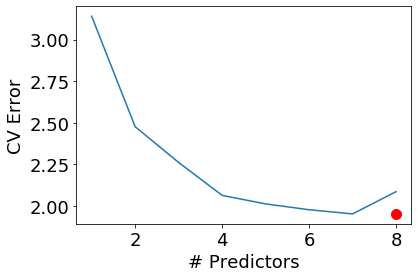

In [37]:
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

We now extract the best model and estimate its parameters using the entire data set

In [38]:
print(sm.OLS(y1,sm.add_constant(X1[models_cv.loc[7, "model"].model.exog_names])).fit().summary())
print(sm.OLS(y,X[models_cv.loc[7, "model"].model.exog_names]).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     141.4
Date:                Thu, 20 Feb 2020   Prob (F-statistic):          5.06e-114
Time:                        10:27:30   Log-Likelihood:                 11.433
No. Observations:                 506   AIC:                            -6.865
Df Residuals:                     498   BIC:                             26.95
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1208      0.414     29.288      0.0